# <center> Assignment 01: Basic to Complex Image classification <br> <br> <small>14 december 2023</small> </center>

The goal of this assignment is :

    - Classify digits dog breed from two kaggle datasets.
    - Try to implement a linear and a non-linear model.
    - Compare the accuracies between models in each task.


## Import libraries

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Lambda, Dropout, Input
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Digit regconizer

**Task:** Classify grey-scale hand-written digits from 0 to 9. The images are 28 x 28 pixels. The training dataset is in csv format, has 42000 records with 784 features from pixel0 to pixel783.

The strategy is to implement the linear model of K-Nearest Neighbors while the non-linear model is a CNN layers.

## Data import

In [30]:
# Load both train and test sets
train_master = pd.read_csv("../Assignment 1/digit-recognizer/train.csv")
test_master = pd.read_csv("../Assignment 1/digit-recognizer/test.csv")

train = train_master.copy().drop("label", axis=1)
label = train_master.label
test = test_master.copy()

In [31]:
print(train.shape)
print(label.shape)
print(test.shape)

(42000, 784)
(42000,)
(28000, 784)


In [32]:
# Inspect a few rows
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Inspect test set to be predicted later
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(33600, 784)
(8400, 784)


## Traditional Machine learning

In [34]:
# K as 1 is enough
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [35]:
# Test
y_pred = knn.predict(X_test.to_numpy())
y_pred

array([8, 1, 9, ..., 3, 0, 9])

### Evaluation

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       816
           1       0.97      1.00      0.98       909
           2       0.98      0.95      0.97       846
           3       0.97      0.96      0.96       937
           4       0.98      0.97      0.97       839
           5       0.96      0.96      0.96       702
           6       0.98      0.99      0.98       785
           7       0.96      0.97      0.96       893
           8       0.98      0.94      0.96       835
           9       0.94      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



> Comment: The KNN model performed quite well with an accuracy of 97%. This shalls be the baseline to compare the CNN model with.

### Test model

In [39]:
test_predict = knn.predict(test.to_numpy())

The digit is 4


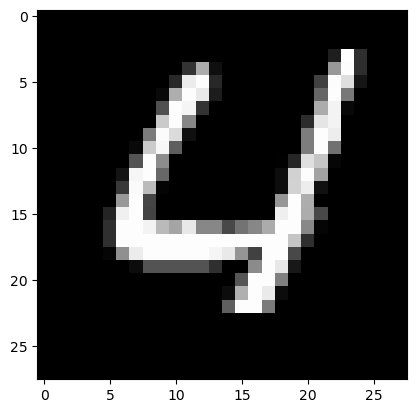

In [40]:
plt.imshow(test.iloc[1200].values.reshape(28, 28), cmap="gray")
print(f'The digit is {test_predict[1200]}')

The digit is 1


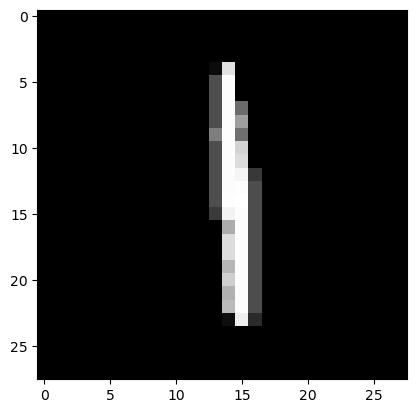

In [41]:
plt.imshow(test.iloc[5000].values.reshape(28, 28), cmap="gray")
print(f'The digit is {test_predict[5000]}')

> We can clearly see the linear model is able to detect digits quite well when we try a couple of examples.

## CNN

### Processing data

In building the CNN, it is a good idea to normalize the data and convert the label with one hot encoder.

In [42]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

In [43]:
n_classes = 10

Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

### Define Model

In [44]:
model = Sequential()

model.add(Dense(100, input_shape=(784,), activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 dense_6 (Dense)             (None, 10)                2010      
                                                                 
Total params: 100710 (393.40 KB)
Trainable params: 100710 (393.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model

In [51]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(X_train_norm, Y_train, batch_size=64, epochs=20, validation_data=(X_test_norm, Y_test))

Epoch 1/20
525/525 [==============================] - 1s 1ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.2845 - val_accuracy: 0.9763
Epoch 2/20
525/525 [==============================] - 1s 952us/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.3080 - val_accuracy: 0.9732
Epoch 3/20
525/525 [==============================] - 1s 1000us/step - loss: 6.8264e-04 - accuracy: 0.9998 - val_loss: 0.2964 - val_accuracy: 0.9756
Epoch 4/20
525/525 [==============================] - 1s 958us/step - loss: 3.2425e-04 - accuracy: 0.9999 - val_loss: 0.3186 - val_accuracy: 0.9745
Epoch 5/20
525/525 [==============================] - 1s 974us/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.3512 - val_accuracy: 0.9726
Epoch 6/20
525/525 [==============================] - 1s 987us/step - loss: 0.0100 - accuracy: 0.9979 - val_loss: 0.3575 - val_accuracy: 0.9740
Epoch 7/20
525/525 [==============================] - 1s 1ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.3698 - val_accu

> Comment:
> So I tried to build a very simple CNN with 3 layers, an input then a calculation and finally an output layer with the first two have "relu" activation while the last has the "softmax".
> After fitting the model, the accuracy of the CNN is closed to the accuracy of the KNN, around 97% depending on the epochs.
> What I can say is: the digits classification task is rather simple and two models performed nearly similar to each others. However, in the next task with identify the dog breed from the image with larger amount of pixels. We will see how the CNN is better.

### Test model

In [53]:
y_pred_cnn = model.predict(test)

875/875 [==============================] - 0s 326us/step


The digit is 0


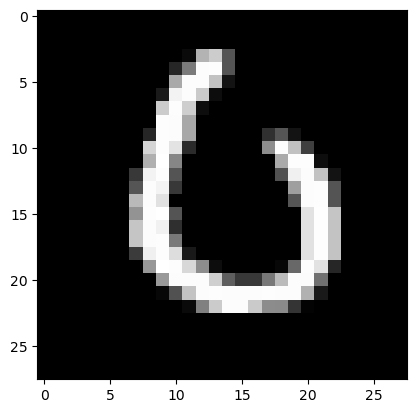

In [54]:
# Test the CNN model
plt.imshow(test.iloc[1900].values.reshape(28, 28), cmap="gray")
print(f'The digit is {np.argmax(y_pred_cnn[1900])}')

The digit is 3


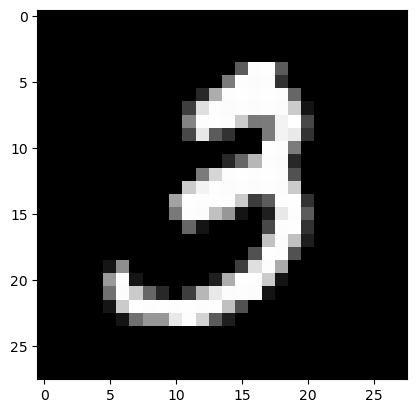

In [55]:
plt.imshow(test.iloc[6900].values.reshape(28, 28), cmap="gray")
print(f'The digit is {np.argmax(y_pred_cnn[6900])}')

# Dog breed

**Task:** Classify different dog breeds from images. The images are in different pixels. The training dataset is a number of dog images with a csv file labelling which breed, there are 10222 images for training.

The same strategy is implemented with one linear model of K-Nearest Neighbors while the non-linear model is a CNN layers.

In [9]:
# Setting some variables
train_path = "../Assignment 1/dog-breed-identification/train/"
labels_path = "../Assignment 1/dog-breed-identification/labels.csv"
img_size = [64, 64, 3]

In [16]:
# Print the number of images in folders
!echo "The number of images in the train folder is: $(ls dog-breed-identification/train/*.jpg | wc -l)"
!echo "The number of images in the test folder is: $(ls dog-breed-identification/test/*.jpg | wc -l)"

The number of images in the train folder is:    10222
The number of images in the test folder is:    10357


## Data import

In [10]:
labels_master = pd.read_csv("../Assignment 1/dog-breed-identification/labels.csv")
labels = labels_master.copy()

In [18]:
len(labels)

10222

In [19]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Adding the path to the dataframe for later use
labels["path"] = train_path + labels.id + ".jpg"
labels.drop("id", axis=1, inplace=True)
labels.head()

,breed,path
0,boston_bull,../Assignment 1/dog-breed-identification/train...
1,dingo,../Assignment 1/dog-breed-identification/train...
2,pekinese,../Assignment 1/dog-breed-identification/train...
3,bluetick,../Assignment 1/dog-breed-identification/train...
4,golden_retriever,../Assignment 1/dog-breed-identification/train...


In [12]:
def create_dataframe(data: pd.DataFrame, img_size: list[int]):
    """ Return a dataframe of pixels of images

    Argument:
    data: Dataframe with image paths and labels
    img_size: pixel sizes
    """
    all_images = []

    # Transform each image to pixels array and add to one big array
    for idx, row in tqdm(data.iterrows(), total=data.shape[0]):
        img = load_img(row['path'], target_size=img_size)
        array_img = img_to_array(img, dtype=np.uint8)
        array_img_t = array_img.flatten()
        all_images.append(array_img_t)

    # Create a dataframe from pixels array
    column_names = [f'pixel{num}' for num in range(len(all_images[0]))]
    df = pd.DataFrame(all_images, columns=column_names)

    return df

In [22]:
X = create_dataframe(labels, img_size)
#len(X)
#X.head()

100%|██████████| 10222/10222 [00:14<00:00, 709.54it/s]


In [13]:
y = labels.breed
y.head()

0         boston_bull
1               dingo
2            pekinese
3            bluetick
4    golden_retriever
Name: breed, dtype: object

In [14]:
y.nunique()

120

In [15]:
# Process the labels for CNN also
le = LabelBinarizer()
y_ohe = le.fit_transform(y)

## Splitting data

In [26]:
X_train_dog, X_test_dog, y_train_dog, y_test_dog = train_test_split(X, y_ohe, test_size=0.2, random_state=42)
print(X_train_dog.shape)
print(X_test_dog.shape)

(8177, 12288)
(2045, 12288)


## Traditional machine learning

In [27]:
# Initially testing if KNN is slow in training
X_train_sample = X_train_dog[:1000]
y_train_sample = y_train_dog[:1000]

In [28]:
knn_2 = KNeighborsClassifier(n_neighbors=1)
#knn_2.fit(X_train_sample, y_train_sample)
knn_2.fit(X_train_dog, y_train_dog)

KNeighborsClassifier(n_neighbors=1)

In [29]:
y_pred_dog = knn_2.predict(X_test_dog.to_numpy())

In [30]:
accuracy_score(y_test_dog, y_pred_dog)

0.033251833740831294

> Comment: As we can clearly see, for the digits task, the KNN performed well but with a much more complex task like dog breed identification, it does not perform well at all.

## CNN

In [16]:
def process_images(data: pd.DataFrame, img_size: list[int] = [224, 224]):
    """ Return the pixels array for CNN

    Argument:
    data: Dataframe with image paths and labels
    img_size: pixel sizes
    """

    # Create a list to hold pixels
    img_arrays = []

    # Transform each image into pixels array
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        img = load_img(row.path, target_size=img_size)
        img_array = img_to_array(img, dtype=np.uint8)
        img_arrays.append(img_array)

    # Convert into a numpy array for the CNN
    one_img_arr = np.array(img_arrays)
    return one_img_arr

In [17]:
X_cnn = process_images(labels)

100%|██████████| 10222/10222 [00:15<00:00, 677.88it/s]


> Comment: With KNN, the pixels size is very important because the higher the size, the longer it takes to convert into array and longer training time. With CNN, it is easier as it can deal with larger pixels size.

In [18]:
X_train_dog_cnn, X_test_dog_cnn, y_train_dog_cnn, y_test_dog_cnn = train_test_split(X_cnn, y_ohe, test_size=.2, random_state=42)

In [19]:
# Normalize data
X_train_dog_cnn = X_train_dog_cnn / 255
X_test_dog_cnn = X_test_dog_cnn / 255

In [26]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3), padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dense(y.nunique(), activation="softmax"))
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 28, 28, 128)      

In [27]:
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [28]:
model_2.fit(X_train_dog_cnn, y_train_dog_cnn, batch_size=64, epochs=10, validation_data=(X_test_dog_cnn, y_test_dog_cnn))

Epoch 1/10
128/128 [==============================] - 313s 2s/step - loss: 4.7931 - accuracy: 0.0088 - val_loss: 4.7850 - val_accuracy: 0.0098
Epoch 2/10
128/128 [==============================] - 347s 3s/step - loss: 4.7833 - accuracy: 0.0087 - val_loss: 4.7849 - val_accuracy: 0.0093
Epoch 3/10
128/128 [==============================] - 348s 3s/step - loss: 4.7823 - accuracy: 0.0098 - val_loss: 4.7837 - val_accuracy: 0.0176
Epoch 4/10
128/128 [==============================] - 366s 3s/step - loss: 4.7802 - accuracy: 0.0087 - val_loss: 4.7832 - val_accuracy: 0.0108
Epoch 5/10
 83/128 [==================>...........] - ETA: 1:55 - loss: 4.7767 - accuracy: 0.0115

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x17de56d40>
Traceback (most recent call last):
  File "/Users/raydi/anaconda3/lib/python3.11/weakref.py", line 369, in remove
KeyboardInterrupt: 

KeyboardInterrupt



> Comment: Build my own CNN model took a long time, so I try the transfer learning approach

In [51]:
# Credit to the HÜSEYIN CENİK team on kaggle for the following code
def get_features(model_name, model_preprocessor, input_size, data: pd.DataFrame):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    maxPool = MaxPooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=maxPool)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [37]:
features = get_features(InceptionV3, inception_preprocess, [224, 224, 3], X_cnn)

320/320 [==============================] - 290s 904ms/step
Feature maps shape: (10222, 2, 2, 2048)


In [38]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(features, y_ohe, test_size=.2, random_state=42)

In [45]:
model_3 = Sequential()

model_3.add(Input(X_train_tf.shape[1:]))
model_3.add(Flatten())
model_3.add(Dropout(0.2))
model_3.add(Dense(128, activation="relu"))
model_3.add(Dense(y.nunique(), activation="softmax"))

model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_3 (Dropout)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 128)               1048704   
                                                                 
 dense_18 (Dense)            (None, 120)               15480     
                                                                 
Total params: 1064184 (4.06 MB)
Trainable params: 1064184 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [50]:
model_3.fit(X_train_tf, y_train_tf, batch_size=64, epochs=20, validation_data=(X_test_tf, y_test_tf))

Epoch 1/20
128/128 [==============================] - 1s 4ms/step - loss: 0.0541 - accuracy: 0.9850 - val_loss: 3.7963 - val_accuracy: 0.7330
Epoch 2/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9828 - val_loss: 3.7289 - val_accuracy: 0.7203
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.0602 - accuracy: 0.9852 - val_loss: 3.7758 - val_accuracy: 0.7188
Epoch 4/20
128/128 [==============================] - 1s 4ms/step - loss: 0.0324 - accuracy: 0.9902 - val_loss: 3.6643 - val_accuracy: 0.7350
Epoch 5/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 0.9835 - val_loss: 3.6609 - val_accuracy: 0.7247
Epoch 6/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0343 - accuracy: 0.9908 - val_loss: 3.7189 - val_accuracy: 0.7311
Epoch 7/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0385 - accuracy: 0.9895 - val_loss: 3.8243 - val_accuracy: 0.7355
Epoch 

> Comment: as we can see the accuracy of the new model performs really well.